# Notebook 5: Adversarial Examples

In this notebook we'll explore __adversarial examples__, an interesting phenomenon in which neural networks can be "fooled" with small changes to their inputs. We'll learn how to craft adversarial examples to fool both image-domain and audio-domain models, and explore ways in which models can be made more robust against these types of attacks.

The notebook is broken up as follows:

  1. [Setup](#setup)  
  2. [What Are Adversarial Examples?](#intro)  
     2.1 [A Simple MNIST Classifier](#mnist)  
     2.2 [Crafting an Adversarial Example](#craft)  
  3. [Audio-Domain Attacks](#audio)  
     3.1. [A Simple AudioMNIST Classifier](#audiomnist)  
     3.2  [Crafting an Audio Adversarial Example](#craft-audio)  
  4. [Building Robust Models](#robust)  

## __1.__ <a name="setup">Setup</a>


Make sure the needed packages are installed and utility code is in the right place.

In [2]:
# Choose basedir as either local or hosted directory
import os
if "COLAB_BACKEND_VERSION" in os.environ:
    base_dir = "/content"
else:
    base_dir = os.getcwd()
# get helper code from the course repository
# install common packages used for deep learning
%cd $base_dir
!git clone https://github.com/cs449s23/lectures.git lectures/
%cd $base_dir/lectures/
!git pull -q origin main
!pip install -q -r requirements.txt

/Users/zachwooddoughty/Documents/CS449Lectures/lectures/notebooks
fatal: destination path 'lectures' already exists and is not an empty directory.
/Users/zachwooddoughty/Documents/CS449Lectures/lectures/notebooks/lectures


In [3]:
%matplotlib inline

import gdown
import time
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchsummary import summary
from tqdm import tqdm

from utils.adversarial_examples import *

In [4]:
# download AudioMNIST dataset in tensor format (this will save time)
!mkdir ./data/
!cd ./data/ && mkdir AudioMNIST

url_x = 'https://drive.google.com/uc?id=1FdLxBSTaH6TuMvBA-wAs-4_kjbEfRSuj'
url_y = 'https://drive.google.com/uc?id=1iMkck7iULEll1HUp_iaYX6rm4LV9mkp6'
out_x = './data/AudioMNIST/audiomnist_tx.pt'
out_y = './data/AudioMNIST/audiomnist_ty.pt'

gdown.download(url_x, out_x, quiet=False)
gdown.download(url_y, out_y, quiet=False)

# AudioMNIST dataset raw download - only do this if gdown fails, as it is SLOW
#%cd ../data
#!git clone https://github.com/soerenab/AudioMNIST.git
#%cd ../code

mkdir: ./data/: File exists


Downloading...
From (uriginal): https://drive.google.com/uc?id=1FdLxBSTaH6TuMvBA-wAs-4_kjbEfRSuj
From (redirected): https://drive.google.com/uc?id=1FdLxBSTaH6TuMvBA-wAs-4_kjbEfRSuj&confirm=t&uuid=2994a853-be3c-42cb-b6ed-166f87f36c25
To: /Users/zachwooddoughty/Documents/CS449Lectures/lectures/notebooks/lectures/data/AudioMNIST/audiomnist_tx.pt
100%|██████████| 1.92G/1.92G [03:48<00:00, 8.41MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iMkck7iULEll1HUp_iaYX6rm4LV9mkp6
To: /Users/zachwooddoughty/Documents/CS449Lectures/lectures/notebooks/lectures/data/AudioMNIST/audiomnist_ty.pt
100%|██████████| 241k/241k [00:00<00:00, 10.0MB/s]


'./data/AudioMNIST/audiomnist_ty.pt'

## __2.__ <a name="intro">What Are Adversarial Examples?</a>

__Adversarial examples__ are inputs to a machine-learning model that have been __perturbed__ (modified), often imperceptibly, so that the model makes an incorrect prediction. The image below, from [Goodfellow et al. (2015)](https://arxiv.org/pdf/1412.6572.pdf), illustrates how an __adversarial perturbation__ can be added to picture of a panda to fool a vision classifier.

<br/>
<center>
<img width="700px" src="https://openaicom.imgix.net/e10713f3-900b-4cb2-8209-201d8c9394a2/adversarial_img_1.png?auto=compress%2Cformat&fit=min&fm=jpg&q=80&rect=0%2C0%2C470%2C178&w=3200"/>
</center>
<br/>

While the adversarial perturbation above looks like random noise, it has actually been carefully crafted to modify this specific image. Recall from the previous notebook that we can think of an image as a point lying in a high-dimensional space. An adversarial perturbation can be thought of as a small vector in this space that we add to our image:

<br/>
<center>
<img width="700px" src="https://drive.google.com/uc?export=view&id=1U-nud0clJMZ76EAcM06vBYL1CQcU5WBl"/>
</center>
<br/>

To find effective perturbation vectors in the input space, we'll use the __gradients of the machine-learning model we wish to fool__. To keep these perturbations relatively imperceptible, we'll constrain the magnitude of our perturbation vector in terms of an __$L_p$ norm__:

$$\|\delta\|_p  = \left( \sum_{i = 1}^{d} \lvert \delta_i \rvert^p \right)^{\frac{1}{p}} $$

where $\delta = \{\delta_1, \dots, \delta_d\}$ is a $d$-dimensional perturbation vector. For example, the $L_2$ norm ($p = 2$) corresponds to the Euclidean norm.

### __2.1__ <a name="mnist">A Simple MNIST Classifier</a>

Before we can begin crafting adversarial examples, we need a classifier to fool. Here, we will download the MNIST dataset and load a pre-trained convolutional neural network to perform classification. Without any adversarial meddling, the network achieves 99% accuracy.

In [6]:
torch.manual_seed(0)  # fix random seed

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# download MNIST data
mnist_train, mnist_test = load_mnist()

# load neural network classifier
model = MNISTClassifier()
model.to(device)

# uncomment this to train a model yourself! Beware, this can take a while on CPU
# train_mnist(model, device, mnist_train, mnist_test)

# load pretrained weights (included with repo)
model.load_state_dict(torch.load('./utils/adversarial_examples/pretrained/mnist_classifier.pt', map_location=device))

# print model summary
print(summary(model, (1, 28, 28)))

# evaluate model
test_mnist(model, device, mnist_test)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
           Dropout-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------
None

Test Accuracy: 9925/10000 (99%)



Given an input image, our model produces a score for each class (digit).

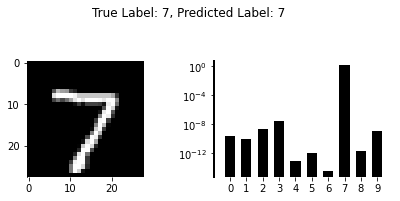

In [7]:
# select an input
batch_x, batch_y = next(iter(mnist_test))
x, y = batch_x[0].to(device), batch_y[0].to(device)

# corresponding image & predicted class scores
plot_mnist(x, y, model)

### __2.2__ <a name="craft">Crafting an Adversarial Example</a>

Image adversarial examples often take the form of small pixel-by-pixel modifications, designed to go unnoticed while changing a neural network's predicted class. Often, an adversary wants to cause a model to predict a specific class; we call this a __targeted__ attack. However, it isn't always obvious a priori how to modify an input to achieve a specific misclassification. For example, adding small pixel-wise random noise may not alter predictions, or may do so unpredictably.


#### Random Noise

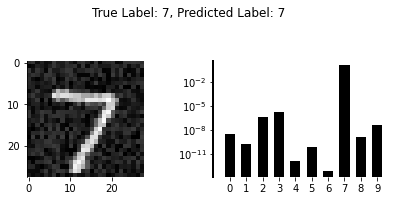

In [8]:
# add random noise
delta = torch.rand_like(x) * 1.0
plot_mnist(x + delta, y, model)

We can construct a perturbation more carefully by leveraging gradient information from our (differentiable) neural network model. When we train a neural network, we perform gradient-based updates on its parameters to guide its output to a desired state (as measured by a classification loss function). Similarly, we can perform gradient-based updates to an _input_ in order to guide the network's output without modifying its parameters. Let $y$ be a __target__ label we want our model $f$ to predict given an input $x$ and adversarial perturbation $\delta$. We can optimize our perturbation by minimizing the objective

$$l(f, x, \delta, y) = NLL\left(f(x + \delta), y\right)$$

as a function of $\delta$, where $NLL$ is a negative log-likelihood (cross-entropy) classification loss. As we update $\delta$ and bring the model's prediction $f(x + \delta)$ closer to $y$, this loss will decrease.

#### Gradients at the Input

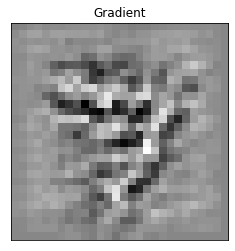

In [9]:
# pick a class we want the network to predict given our adversarial input
target = torch.tensor([9]).to(device)

# our input image; make sure we tell PyTorch to track its gradients
x = x.reshape(1, 1, 28, 28).requires_grad_(True)

# clear gradients
x.grad = None

# do not compute gradients for model parameters - only the input
for p in model.parameters():
    p.requires_grad = False
model.eval()

# pass through model and compute loss: how "far" is prediction from target?
outputs = model(x)  
loss = torch.nn.functional.nll_loss(outputs, target)

# compute gradient of loss w.r.t. our input
loss.backward()

# plot gradient
grad = x.grad.detach().cpu()
plt.title("Gradient")
plt.imshow(grad.reshape(28, 28).numpy(), cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

We can iteratively update our input using these gradients to craft an adversarial example that minimizes our classification loss. In its most basic form, a gradient-based attack might look like the following:

#### Simple Update

In [ ]:
# pick a class we want the network to predict given our adversarial input
target = torch.tensor([6]).to(device)

x = x.reshape(1, 1, 28, 28).detach()

# iteratively optimize an additive perturbation to our input
delta = torch.zeros_like(x).requires_grad_(True)

# perturbation "training" loop
for i in range(1, 100):

    # clear gradients each step
    delta.grad = None

    # compute model's class scores given perturbed input (x + delta)
    outputs = model(x + delta)  

    # log current prediction
    if not i % 10:
        print(f"Iteration: {i}; Prediction: {outputs.argmax()}")

    # compute loss: how "far" is prediction from target?
    loss = torch.nn.functional.nll_loss(outputs, target)

    # compute gradient of loss w.r.t. our perturbation
    loss.backward()
    grad = delta.grad.detach()

    # update our perturbation to descend the loss
    with torch.no_grad():

        # update with raw gradients
        delta -= grad
    
# plot final prediction
plot_mnist(x + delta.detach(), y, model)

# plot perturbation (difference between benign and adversarial inputs)
plt.title("Perturbation")
plt.imshow(delta.detach().cpu().reshape(28, 28).numpy(), cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

We've successfully modified our input to achieve our target label! Notice that our perturbation is concentrated around the center of the image, where the most salient features presumably lie. Alternatively, to try and "spread" our perturbation uniformly over the image, we might regulate the allowed perturbation magnitude at each pixel. One way to do so is by clipping the perturbation and taking uniform-magnitude steps along the gradient. This is referred to as an $L_\infty$ __Projected Gradient Descent (PGD)__ attack: clipping can be considered a projection of the perturbation onto the $L_{\infty}$ norm ball centered at the origin, or equivalently of the adversarial input onto the $L_\infty$ norm ball centered at the original input. That is, clipping contrains the $L_\infty$ norm of the perturbation.

#### $L_\infty$ PGD

Iteration: 10; Prediction: 7
Iteration: 20; Prediction: 9
Iteration: 30; Prediction: 9
Iteration: 40; Prediction: 9
Iteration: 50; Prediction: 9
Iteration: 60; Prediction: 9
Iteration: 70; Prediction: 9
Iteration: 80; Prediction: 9
Iteration: 90; Prediction: 9


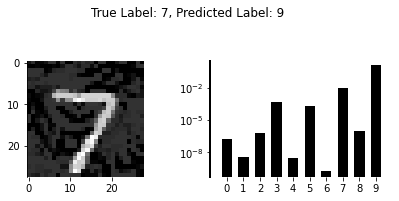

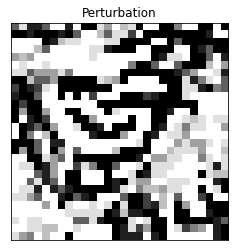

In [11]:
# pick a class we want the network to predict given our adversarial input
target = torch.tensor([9]).to(device)

x = x.reshape(1, 1, 28, 28)

# iteratively optimize an additive perturbation to our input
delta = torch.zeros_like(x).requires_grad_(True)

# "training" loop
for i in range(1, 100):

    # clear gradients each step
    delta.grad = None

    # compute model's class scores given perturbed input (x + delta)
    outputs = model(x + delta)  

    # log current prediction
    if not i % 10:
        print(f"Iteration: {i}; Prediction: {outputs.argmax()}")

    # compute loss: how "far" is prediction from target?
    loss = torch.nn.functional.nll_loss(outputs, target)

    # compute gradient of loss w.r.t. our perturbation
    loss.backward()
    grad = delta.grad.detach()

    # update our perturbation to descend the loss
    with torch.no_grad():

        # take uniform steps along the gradient for all pixels
        delta -= torch.sign(grad) * 0.1

        # bound the magnitude of the perturbation at each iteration
        delta.clip_(min=-0.4, max=0.4)

# plot final prediction
plot_mnist(x + delta.detach(), y, model)


# plot perturbation (difference between benign and adversarial inputs)
plt.title("Perturbation")
plt.imshow(delta.detach().cpu().reshape(28, 28).numpy(), cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

This looks a little better! Note that we're not limited to considering the $L_\infty$ norm; we could also perform an $L_2$ PGD attack, replacing our clipping operation with simple Euclidean normalization of the perturbation and dropping the `sign` operation. By now, it's hopefully clear that there are numerous ways to tweak our attacks: we could run for more iterations in the hope of finding a better perturbation, or scale our updates to adjust our effective "learning rate". Often, these tweaks will __trade-off between the effectiveness of our attacks in fooling the network and their perceptibility__.

A final tweak to consider is incorporating magnitude constraints into the loss function via a __Lagrangian relaxation__. The idea is to penalize the magnitude of our perturbation (as measured by an $L_p$ norm) rather than constraining it explicitly. We can think of such an attack as optimizing two losses in tandem: $l_\mathrm{adv}$, which measures our success in fooling the network, and $l_\mathrm{aux}$, an auxiliary loss which imposes constraints on the perturbation. For input $x$, target label $y$, perturbation $\delta$, and neural network $f$, we can write this as

\begin{align}
l(f, x, \delta, y) &= l_\mathrm{adv}(f(x + \delta), y) + \lambda \cdot l_\mathrm{aux}(\delta) \\[3mm]
&= NLL(f(x + \delta), y) + \lambda \cdot \| \delta \|_2
\end{align}

where $NLL$ is our negative log-likelihood (cross-entropy) classification loss and $\lambda$ controls the relative weight of our loss terms.

#### Lagrangian Relaxation

Iteration: 10; Prediction: 7
Iteration: 20; Prediction: 7
Iteration: 30; Prediction: 7
Iteration: 40; Prediction: 7
Iteration: 50; Prediction: 7
Iteration: 60; Prediction: 7
Iteration: 70; Prediction: 7
Iteration: 80; Prediction: 9
Iteration: 90; Prediction: 9
Iteration: 100; Prediction: 9


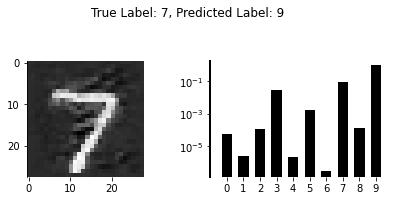

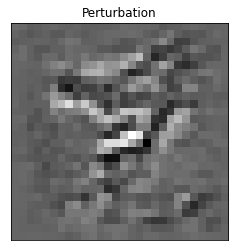

In [12]:
# pick a class we want the network to predict given our adversarial input
target = torch.tensor([9]).to(device)

x = x.reshape(1, 1, 28, 28)

# iteratively optimize an additive perturbation to our input
delta = torch.zeros_like(x).requires_grad_(True)

# "training" loop
for i in range(1, 101):

    # clear gradients each step
    delta.grad = None

    # log current prediction
    if not i % 10:
        print(f"Iteration: {i}; Prediction: {outputs.argmax()}")
    
    # compute model's class scores given perturbed input (x + delta)
    outputs = model(x + delta)  

    # compute loss: matching target + penalizing perturbation magnitude
    loss = torch.nn.functional.nll_loss(outputs, target) + 0.3 * delta.norm()

    # compute gradient of loss w.r.t. our perturbation
    loss.backward()
    grad = delta.grad.detach()

    # update our perturbation to descend the loss
    with torch.no_grad():

        # update with raw gradients
        delta -= (grad/(grad.norm() + 1e-12)) * 0.1

# plot final prediction
plot_mnist(x + delta.detach(), y, model)

# plot perturbation (difference between benign and adversarial inputs)
plt.title("Perturbation")
plt.imshow(delta.detach().cpu().reshape(28, 28).numpy(), cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

And with that, we'll take a break from image attacks and move on to the audio domain.

## __3.__ <a name="audio">Audio-Domain Attacks</a>

Having seen a few basic attacks in the image domain, we'll now pivot to audio. First, we'll swap our MNIST classification task for an analogous AudioMNIST spoken digit recognition task. Then, we'll survey existing audio-domain attacks and examine how they navigate the differences between visual and auditory media.

### __3.1__ <a name="audiomnist">A Simple AudioMNIST Classifier</a>

The [AudioMNIST dataset](https://github.com/soerenab/AudioMNIST) comprises 30,000 one-second recordings of spoken digits (0-9) from 60 different speakers. Whereas the grayscale images in the MNIST dataset had an inherent two-dimensional spatial structure that we could exploit with a convolutional neural network, __audio is typically stored in a one-dimensional _waveform_ representation__. There are two common ways to deal with this: use _one-dimensional convolutions_ in our neural network, or convert the audio to a _two-dimensional representation_ and apply standard image-domain techniques. We'll opt for the former, using the AudioNet model proposed by [Becker et al.](https://arxiv.org/abs/1807.03418)

Validation, batch 1/47:   0%|          | 0/47 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 100, 16002]             400
       BatchNorm1d-2           [-1, 100, 16002]             200
              ReLU-3           [-1, 100, 16002]               0
         MaxPool1d-4            [-1, 100, 8000]               0
            Conv1d-5             [-1, 64, 8000]          19,264
       BatchNorm1d-6             [-1, 64, 8000]             128
              ReLU-7             [-1, 64, 8000]               0
         MaxPool1d-8             [-1, 64, 4000]               0
            Conv1d-9            [-1, 128, 4000]          24,704
      BatchNorm1d-10            [-1, 128, 4000]             256
             ReLU-11            [-1, 128, 4000]               0
        MaxPool1d-12            [-1, 128, 2000]               0
           Conv1d-13            [-1, 128, 2000]          49,280
      BatchNorm1d-14            [-1, 12

Validation, batch 47/47: 100%|██████████| 47/47 [05:53<00:00,  7.52s/it]



Model accuracy: 98.0


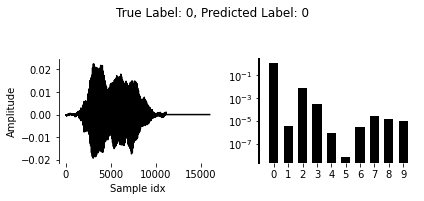

In [13]:
torch.manual_seed(0)  # fix random seed

# load AudioMNIST dataset (if you opted to download via GitHub, this will cache the dataset as tensors)
audiomnist_train, audiomnist_test = load_audiomnist("./data/AudioMNIST")

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load neural network classifier
model = AudioNet()
model.to(device)

# print model summary
summary(model, (1, 16000))

# uncomment this to train a model yourself! 
#train_audiomnist(model, device, audiomnist_train, audiomnist_test, epochs=10)

# load pretrained weights
model.load_state_dict(torch.load('./utils/adversarial_examples/pretrained/audiomnist_classifier.pt', map_location=device))

# evaluate model. This may take a while on CPU, and should be ~98%
test_audiomnist(model, device, audiomnist_test)

# plot and play an AudioMNIST example
batch_x, batch_y = next(iter(audiomnist_test))
x, y = batch_x[100:101].to(device), batch_y[100:101].to(device)

plot_audiomnist(x, y, model)
play_audiomnist(x)

### __3.2__ <a name="craft-audio">Crafting an Audio Adversarial Example</a>

Just as we attacked an image classifier by making small alterations in pixel space, we can attack an audio classifier by making small alterations to the waveform. First, let's see where random noise gets us:

#### Random Noise

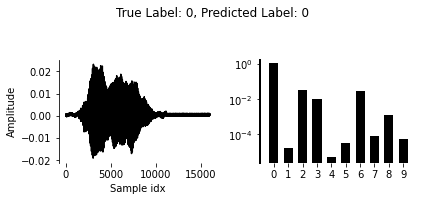

In [14]:
# add random noise
delta = torch.rand_like(x) * 0.001
plot_audiomnist(x + delta, y, model)
play_audiomnist(x + delta)

Just as before, we see (or hear) that we may fail to change the model's prediction even when adding a very perceptible amount of random noise. How can we perturb the input more precisely? With gradients!

#### Gradients at the Input

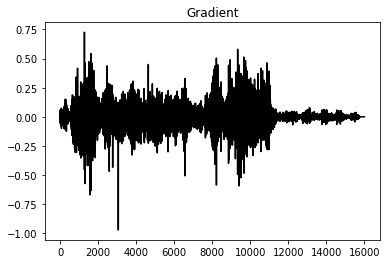

In [15]:
# pick a class we want the network to predict given our adversarial input
target = torch.tensor([0]).to(device)

# our input audio
x = x.detach().reshape(1, 1, 16000).requires_grad_(True)

# clear gradients
x.grad = None

# do not tack gradients for model -- only input
for p in model.parameters():
    p.requires_grad = False
model.eval()

# pass through model and compute loss: how "far" is prediction from target?
outputs = model(x)  
loss = torch.nn.functional.cross_entropy(outputs, target)

# compute gradient of loss w.r.t. our input
loss.backward()

# plot gradient
grad = x.grad.detach().cpu().flatten().numpy()
plt.title("Gradient")
plt.plot(grad, 'k-')
plt.show()

play_audiomnist(x.grad)

Just as before, we can iteratively update our input using these gradients to craft an adversarial example that minimizes our classification loss. Note the large magnitude of these gradients relative to the input waveform. To avoid scale issues, we can use the $L_\infty$ PGD attack discussed earlier.

#### $L_\infty$ PGD

Iteration: 1; Prediction: 0
Iteration: 2; Prediction: 0
Iteration: 3; Prediction: 0
Iteration: 4; Prediction: 0
Iteration: 5; Prediction: 0
Iteration: 6; Prediction: 0
Iteration: 7; Prediction: 0
Iteration: 8; Prediction: 0
Iteration: 9; Prediction: 0
Iteration: 10; Prediction: 0


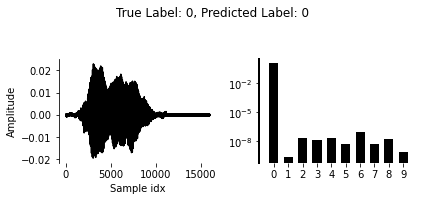

In [16]:
# pick a class we want the network to predict given our adversarial input
target = torch.tensor([0]).to(device)

x = x.detach().reshape(1, 1, 16000).requires_grad_(False)

# iteratively optimize an additive perturbation to our input
delta = torch.zeros_like(x).requires_grad_(True)

# "training" loop
for i in range(1, 11):

    # clear gradients each step
    delta.grad = None

    # compute model's class scores given perturbed input (x + delta)
    outputs = model(x + delta)  

    # log current prediction
    print(f"Iteration: {i}; Prediction: {outputs.argmax()}")

    # compute loss: how "far" is prediction from target?
    loss = torch.nn.functional.cross_entropy(outputs, target)

    # compute gradient of loss w.r.t. our perturbation
    loss.backward()
    grad = delta.grad.detach()

    # update our perturbation to descend the loss
    with torch.no_grad():

        # take uniform steps along the gradient for all samples
        delta -= torch.sign(grad) * 0.0001

        # bound the magnitude of the perturbation at each iteration
        delta.clip_(min=-0.0005, max=0.0005)

# plot final prediction
plot_audiomnist(x + delta.detach(), y, model)
play_audiomnist((x + delta))

Note that we had to carefully pick our step size and allow sufficient iterations for our optimization to converge to an effective adversarial example. Also note that while our perturbation is small in magnitude, it is easily perceptible as noise. As before, we can try using an __auxiliary loss (Lagrangian relaxation)__ to penalize the magnitude of our perturbation and make it harder to hear.

#### Lagrangian Relaxation

Iteration: 20; Prediction: 0
Iteration: 40; Prediction: 0
Iteration: 60; Prediction: 0
Iteration: 80; Prediction: 0
Iteration: 100; Prediction: 0
Iteration: 120; Prediction: 0
Iteration: 140; Prediction: 0
Iteration: 160; Prediction: 0
Iteration: 180; Prediction: 0
Iteration: 200; Prediction: 0


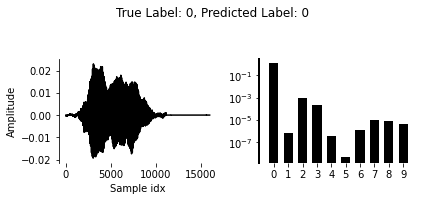

In [17]:
# pick a class we want the network to predict given our adversarial input
target = torch.tensor([0]).to(device)

x = x.detach().reshape(1, 1, 16000)

# iteratively optimize an additive perturbation to our input
delta = torch.zeros_like(x).requires_grad_(True)

# "training" loop
for i in range(1, 201):

    # clear gradients each step
    delta.grad = None

    # compute model's class scores given perturbed input (x + delta)
    outputs = model(x + delta)  

    # log current prediction
    if not i % 20:
        print(f"Iteration: {i}; Prediction: {outputs.argmax()}")

    # compute loss: how "far" is prediction from target?
    loss = torch.nn.functional.cross_entropy(outputs, target) + 400 * delta.norm()

    # compute gradient of loss w.r.t. our perturbation
    loss.backward()
    grad = delta.grad.detach()

    # update our perturbation to descend the loss
    with torch.no_grad():

        # take uniform-magnitude steps along the gradient for all samples
        delta -= (grad/(grad.norm() + 1e-12)) * 0.005

# plot final prediction
plot_audiomnist(x + delta.detach(), y, model)
play_audiomnist((x + delta))

That certainly helps a bit -- our perturbation is less conspicuous than before, although still hard to miss. Interestingly, while small noisy perturbations can be hard to spot in the image domain, they are often quite easy to hear in the audio domain. In order to craft stealthier audio perturbations, we'll have to get creative.

In our Lagrangian relaxation above, we used a simple $L_2$ penalty as our auxiliary loss. However, due to the complex nature of human auditory perception, the $L_2$ norm of an audio signal does not necessarily correspond well with its "perceptibility." To improve on this front, we can swap in an auxliary loss designed to mimic the ways in which the human ear is sensitive to sound -- namely, by leveraging the phenomenon of _frequency masking_.

#### Frequency Masking

Computing masking thresholds: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]
/Users/zachwooddoughty/Library/Python/3.8/lib/python/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:867.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


Iteration: 100; Prediction: 0; L_adv: 0.00632048724219203; L_aux: 0.0
Iteration: 200; Prediction: 0; L_adv: 0.00632048724219203; L_aux: 0.0
Iteration: 300; Prediction: 0; L_adv: 0.00632048724219203; L_aux: 0.0
Iteration: 400; Prediction: 0; L_adv: 0.00632048724219203; L_aux: 0.0
Iteration: 500; Prediction: 0; L_adv: 0.00632048724219203; L_aux: 0.0


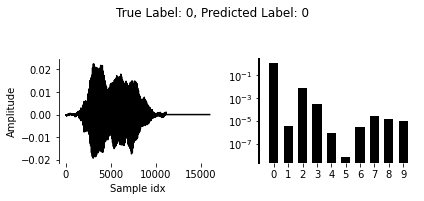

In [18]:
# initialize an object to compute auxiliary (frequency-masking) loss
fm_loss = FrequencyMaskingLoss()

# store "clean" version of waveform as perceptual reference
fm_loss.set_reference(x)

# pick a class we want the network to predict given our adversarial input
target = torch.tensor([0]).to(device)

# iteratively optimize an additive perturbation to our input
delta = torch.zeros_like(x).requires_grad_(True)

# "training" loop
for i in range(1, 501):

    # clear gradients each step
    delta.grad = None

    # compute model's class scores given perturbed input (x + delta)
    outputs = model(x + delta)  

    # compute losses: how "far" is prediction from target? how perceptible is perturbation?
    l_adv = torch.nn.functional.cross_entropy(outputs, target)
    l_aux = fm_loss(x + delta, x)

    # we'll stop optimizing the adversarial loss after we reach a value of 0.05. This will
    # let us focus on the auxiliary loss, making our perturbation less perceptible
    loss = torch.nn.functional.relu(l_adv-0.05) + l_aux

    # log current prediction
    if not i % 100:
        print(f"Iteration: {i}; Prediction: {outputs.argmax()}; L_adv: {l_adv.item()}; L_aux: {l_aux.item()}")

    # compute gradient of loss w.r.t. our perturbation
    loss.backward()
    grad = delta.grad.detach()

    # update our perturbation to descend the loss
    with torch.no_grad():

        # take uniform steps along the gradient for all samples
        delta -= (grad/(grad.norm() + 1e-12)) * 1e-4
        
# plot final prediction
plot_audiomnist(x + delta.detach(), y, model)
play_audiomnist((x + delta))

For reference, here's the original (unperturbed) audio:

In [19]:
play_audiomnist(x)

## __4.__ <a name="robust">Building Robust Models</a>

We've explored a number of ways to craft adversarial examples. While these approaches relied on direct access to the model we were attempting to fool, it turns out that adversarial examples can often __transfer__ to unseen models and have similar effects. Additionally, __black-box__ optimization approaches can allow attackers to craft adversarial examples with only query access to a victim model. These factors mean that adversarial examples may pose a nontrivial risk to machine-learning systems in certain sensitive applications. So how can we prevent malicious actors from surreptitiously influencing the behavior of neural network systems?

One __adversarial defense__, called __randomized smoothing__, applies random transformations to many copies of an input and takes a majority vote over the model's predictions on the transformed inputs.

#### Randomized Smoothing

In [20]:
# use our frequency-masked perturbation from above
adv_input = x + delta

print(f"Original prediction: {model(x).argmax().item()}")
print(f"Adversarial prediction (no randomized smoothing): {model(adv_input).argmax().item()}")

# generate 100 "noisy" versions of our input and get a prediction for each
noisy_predictions = []
for i in range(100):
    noisy_predictions.append(
        model(adv_input + torch.randn_like(adv_input)*0.0001).argmax().item()
    )

# take most common prediction
mode = max(set(noisy_predictions), key=noisy_predictions.count)
    
print(f"Adversarial prediction (randomized smoothing): {mode}")

Original prediction: 0
Adversarial prediction (no randomized smoothing): 0
Adversarial prediction (randomized smoothing): 0


This can work well against small, "brittle" adversarial perturbations which will be effectively "drowned out" by the noise. However, there are still plenty of issues with this approach. For example, adversaries can include random noise in their optimization process to craft perturbations capable of withstanding noise. Additionally, in order to beat larger perturbations, randomized smoothing must use a correspondingly larger amount of noise at inference time, resulting in inaccurate predictions.

Other adversarial defenses attempt to detect malicious inputs using a variety of heuristics. However, these defenses often fail to provide meaningful guarantees against __adaptive__ attackers with knowledge of the defense. Currently, one of the best known approaches to prevent attacks is __adversarial training__, in which a model is trained on adversarial examples. This can provide some degree of robustness against attacks similar to those seen during training.

#### Adversarial Training

In [ ]:
# we'll start by wrapping our adversarial example code in a function
def make_adversarial_example(x: torch.Tensor, model: torch.nn.Module, steps: int):
    
    # require batch dimension
    assert x.ndim >= 2
    n_batch = x.shape[0]
    
    x = x.detach().reshape(n_batch, 1, 16000)
    delta = torch.zeros_like(x).requires_grad_(True)
    
    # obtain original predictions; we'll perform an `untargeted` attack in which we simply
    # seek incorrect predictions rather than a specific class
    with torch.no_grad():
        preds = model(x).argmax(dim=-1).long()

    # evaluation mode
    model.eval()
    
    for i in range(steps):

        delta.grad = None
           
        outputs = model(x + delta)  
        loss = torch.nn.functional.cross_entropy(outputs, preds)

        loss.backward()
        grad = delta.grad.detach()

        with torch.no_grad():
            
            # ascend rather than descend the gradient (untargeted attack)
            delta += (grad/(grad.norm() + 1e-12)) * 0.005
    
    # restore train mode
    model.train()
    
    return(x + delta.detach())


# choose how many attack steps we perform -- more steps means more robustness, but at the
# cost of a linear increase in training time
attack_steps = 5

# number of epochs to train for
epochs = 5

# initialize the model
robust_model = AudioNet()
robust_model.to(device)

# use an optimizer to handle parameter updates
optimizer = torch.optim.SGD(
    robust_model.parameters(), lr=0.001, momentum=0.9
)

# train using categorical cross-entropy loss
criterion = torch.nn.CrossEntropyLoss()

# keep track of accuracy; ultimately, we will choose the most accurate model
best_acc = 0.0
best_model = None

for epoch in range(epochs):

    # track loss
    training_loss = 0.0
    validation_loss = 0

    # track accuracy
    correct = 0
    total = 0

    pbar = tqdm(audiomnist_train, total=len(audiomnist_train))

    model.train()
    for batch_idx, batch_data in enumerate(pbar):

        pbar.set_description(
            f'Epoch {epoch + 1}, batch {batch_idx + 1}/{len(audiomnist_train)}')

        inputs, labels = batch_data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # adversarially perturb inputs
        inputs = make_adversarial_example(inputs, robust_model, attack_steps)
        
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = robust_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # sum training loss
        training_loss += loss.item()

    model.eval()
    with torch.no_grad():

        pbar = tqdm(audiomnist_test, total=len(audiomnist_test))
        for batch_idx, batch_data in enumerate(pbar):

            pbar.set_description(
                f'Validation, batch {batch_idx + 1}/{len(audiomnist_test)}')

            inputs, labels = batch_data

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = robust_model(inputs)

            loss = criterion(outputs, labels)

            # sum validation loss
            validation_loss += loss.item()

            # calculate validation accuracy
            preds = torch.max(outputs.data, 1)[1]

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    # calculate final metrics
    validation_loss /= len(audiomnist_test)
    training_loss /= len(audiomnist_train)
    accuracy = 100 * correct / total

    # if best model thus far, save
    if accuracy > best_acc:
        print(f"New best accuracy: {accuracy}; saving model")
        best_model = copy.deepcopy(robust_model.state_dict())
        best_acc = accuracy

# use best weights
robust_model.load_state_dict(best_model)

# evaluate robust model's accuracy on "natural" (non-adversarial) data
test_audiomnist(robust_model, device, audiomnist_test)

Epoch 1, batch 73/375:  19%|█▉        | 72/375 [1:41:12<37:38:00, 447.13s/it]

In [ ]:
# compare predictions!
print(f"Original prediction: {model(x).argmax().item()}")
print(f"Adversarial prediction (non-robust model): {model(adv_input).argmax().item()}")
print(f"Adversarial prediction (robust model): {robust_model(adv_input).argmax().item()}")